## Setup

N.B. Based on an [OpenAI example notebook](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_finetune_chat_models.ipynb). [gptchem](https://github.com/kjappelbaum/gptchem) uses an outdated version of the OpenAI API.

In [2]:
from typing import Union, List, Dict
import pathlib as pl
import json
import os
from datetime import datetime

import openai
import tiktoken
import pandas as pd
from rdkit import Chem
from sklearn.model_selection import train_test_split

from ai4chem.utils import randomize_smiles
from ai4chem.tokenizers import gpt_num_tokens_from_messages

with open('/Users/azadoks/.zshrc.d/10_openai_bot.sh', 'r') as f:
    api_key = f.read().split('=')[1].strip()

client = openai.OpenAI(api_key=api_key)

In [55]:
train_df = pd.read_json('../data/combined/train.json')
validate_df = pd.read_json('../data/combined/validate.json')
test_df = pd.read_json('../data/combined/test.json')

## Data preparation

In [56]:
def get_system_message(property_name: str) -> str:
    return f"You predict properties of molecules with high accuracy to assist chemists. You are to predict the {property_name} maximum wavelength in nanometers of the provided molecule when dissolved in the provided solvent."

def get_user_message(row, representation: Union[str, List[str]]="SMILES") -> str:
    def _get_molecule_line(row, representation: str) -> str:
        return f"Molecule {representation}: {row[f'CHROMOPHORE_{representation}']}"
    def _get_solvent_line(row, representation: str) -> str:
        return f"Solvent {representation}: {row[f'SOLVENT_{representation}']}"

    if isinstance(representation, str):
        molecule_lines = _get_molecule_line(row, representation)
        solvent_lines = _get_solvent_line(row, representation)
    else:
        molecule_lines = "\n".join([_get_molecule_line(row, rep) for rep in representation])
        solvent_lines = "\n".join([_get_solvent_line(row, rep) for rep in representation])

    return f'{molecule_lines}\n\n{solvent_lines}'

def get_train_conversation(row, property_name: str, representation: Union[str, List[str]]="SMILES") -> Dict:
    messages = []
    messages.append({'role': 'system', 'content': get_system_message(property_name)})
    messages.append({'role': 'user', 'content': get_user_message(row, representation)})
    property_key = f'{property_name.upper()}_MAX_NM'
    messages.append({'role': 'assistant', 'content': f'{int(row[property_key]):4d} nm'})
    return {'messages': messages}

def get_test_conversation(row, property_name: str, representation: Union[str, List[str]]="SMILES") -> Dict:
    messages = []
    messages.append({'role': 'system', 'content': get_system_message(property_name)})
    messages.append({'role': 'user', 'content': get_user_message(row, representation)})
    property_key = f'{property_name.upper()}_MAX_NM'
    return {'messages': messages}, f'{int(row[property_key]):4d} nm'

def get_prompt(row, property_name: str, representation: Union[str, List[str]]="SMILES") -> str:
    return f"The predicted {property_name} maximum wavelength of the molecule {row[f'CHROMOPHORE_{representation}']} when dissolved in {row[f'SOLVENT_{representation}']} is:"

def get_completion(row, property_name: str) -> str:
    property_key = f'{property_name.upper()}_MAX_NM'
    return f'{int(row[property_key]):4d} nm'

def get_train_prompt_response(row, property_name: str, representation: Union[str, List[str]]="SMILES") -> Dict:
    return {
        'prompt': get_prompt(row, property_name, representation),
        'completion': get_completion(row, property_name)
    }

def write_jsonl(data: list, filename: os.PathLike) -> None:
    with open(filename, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

def count_tokens(data: List[Dict]) -> int:
    return sum(
        gpt_num_tokens_from_messages(row['messages'], model="gpt-3.5-turbo-0613")
        for row in data
    )

In [66]:
property_name = "emission"
representation = "SMILES"
model_name = "babbage-002"

experiment_name = f'{representation.lower()[:3]}-{property_name[:3].lower()}-{model_name[:1].lower()}{datetime.now().strftime("%d%H%M")}'

if 'gpt' in model_name:
    train_data = train_df.apply(lambda row: get_train_conversation(row, property_name, representation), axis=1).tolist()
    validate_data = validate_df.apply(lambda row: get_train_conversation(row, property_name, representation), axis=1).tolist()
    test_data = test_df.apply(lambda row: get_train_conversation(row, property_name, representation), axis=1).tolist()
elif 'babbage' or 'davinci' in model_name:
    train_data = train_df.apply(lambda row: get_train_prompt_response(row, property_name, representation), axis=1).tolist()
    validate_data = validate_df.apply(lambda row: get_train_prompt_response(row, property_name, representation), axis=1).tolist()
    test_data = test_df.apply(lambda row: get_train_prompt_response(row, property_name, representation), axis=1).tolist()

for conversation in train_data[:5]:
    print(conversation)

{'prompt': 'The predicted emission maximum wavelength of the molecule CC1=C(C(C)(C)C)C(C)=[N+]2C1=C(C)c1c(C)c(C(C)(C)C)c(C)n1[B-]2(F)F when dissolved in CCC(C)C is:', 'completion': ' 569 nm'}
{'prompt': 'The predicted emission maximum wavelength of the molecule COc1ccc2nn(C)c(-c3ccc(C(C)=O)o3)c2c1 when dissolved in CC#N is:', 'completion': ' 458 nm'}
{'prompt': 'The predicted emission maximum wavelength of the molecule CCCCN(CCCC)c1ccc(C#Cc2cc(C#Cc3ccc([N+](=O)[O-])cc3)c(C#Cc3ccc([N+](=O)[O-])cc3)cc2C#Cc2ccc(N(CCCC)CCCC)cc2)cc1 when dissolved in ClCCl is:', 'completion': ' 563 nm'}
{'prompt': 'The predicted emission maximum wavelength of the molecule Cc1cc(/C=C/c2ccccc2Oc2ccc(F)cc2)n2c1C=C1C=CC=[N+]1[B-]2(F)F when dissolved in CS(C)=O is:', 'completion': ' 574 nm'}
{'prompt': 'The predicted emission maximum wavelength of the molecule CN(C)c1ccc(/C=C/c2ccccn2)cc1 when dissolved in O is:', 'completion': ' 512 nm'}


In [67]:
experiment_data_path = pl.Path(f'../data/{experiment_name}')
experiment_data_path.mkdir(exist_ok=True)

train_filename = str(experiment_data_path / "train.jsonl")
write_jsonl(train_data, train_filename)

validate_filename = str(experiment_data_path / "validate.jsonl")
write_jsonl(validate_data, validate_filename)

test_filename = str(experiment_data_path / "test.jsonl")
write_jsonl(test_data, test_filename)

!head -n 5 $train_filename
!wc -l $train_filename
!wc -l $validate_filename
!wc -l $test_filename

{"prompt": "The predicted emission maximum wavelength of the molecule CC1=C(C(C)(C)C)C(C)=[N+]2C1=C(C)c1c(C)c(C(C)(C)C)c(C)n1[B-]2(F)F when dissolved in CCC(C)C is:", "completion": " 569 nm"}
{"prompt": "The predicted emission maximum wavelength of the molecule COc1ccc2nn(C)c(-c3ccc(C(C)=O)o3)c2c1 when dissolved in CC#N is:", "completion": " 458 nm"}
{"prompt": "The predicted emission maximum wavelength of the molecule CCCCN(CCCC)c1ccc(C#Cc2cc(C#Cc3ccc([N+](=O)[O-])cc3)c(C#Cc3ccc([N+](=O)[O-])cc3)cc2C#Cc2ccc(N(CCCC)CCCC)cc2)cc1 when dissolved in ClCCl is:", "completion": " 563 nm"}
{"prompt": "The predicted emission maximum wavelength of the molecule Cc1cc(/C=C/c2ccccc2Oc2ccc(F)cc2)n2c1C=C1C=CC=[N+]1[B-]2(F)F when dissolved in CS(C)=O is:", "completion": " 574 nm"}
{"prompt": "The predicted emission maximum wavelength of the molecule CN(C)c1ccc(/C=C/c2ccccn2)cc1 when dissolved in O is:", "completion": " 512 nm"}
    5000 ../data/smi-emi-b231214/train.jsonl
     100 ../data/smi-emi-b231

In [68]:
with open(train_filename, "rb") as train_fd:
    training_response = client.files.create(
        file=train_fd, purpose="fine-tune"
    )

train_file_id = training_response.id

with open(validate_filename, "rb") as validate_fd:
    validate_response = client.files.create(
        file=validate_fd, purpose="fine-tune"
    )
validate_file_id = validate_response.id

print(experiment_name)
print("Training file ID:", train_file_id)
print("Validation file ID:", validate_file_id)

smi-emi-b231214
Training file ID: file-byylEQQbHdtnsEcLFsV5QMYr
Validation file ID: file-avQ48DibtbXQ4ZEhWQC59tSF


In [69]:
response = client.fine_tuning.jobs.create(
    training_file=train_file_id,
    validation_file=validate_file_id,
    model="babbage-002",
    suffix=experiment_name,
)

job_id = response.id

print("Job ID:", response.id)
print("Status:", response.status)

with open(experiment_data_path / "job_id.txt", "w") as f:
    f.write(job_id)

Job ID: ftjob-Qp2A5vkwnDgK7ZoFUYECKyIn
Status: validating_files


In [24]:
gpt_gen = [{
    "MOLECULE_NAME": '9,10-Diphenylanthracene',
    "SOLVENT_NAME": 'Toluene',
    "MOLECULE_SMILES": "C1=CC=C(C=C1)C2=CC3=CC=CC=C3C=C2",
}, {
    "MOLECULE_NAME": '9,10-Diphenylanthracene',
    "SOLVENT_NAME": 'Dichloromethane',
    "MOLECULE_SMILES": "C1=CC=C(C=C1)C2=CC3=CC=CC=C3C=C2",
}, {
    "MOLECULE_NAME": 'Pyrene',
    "SOLVENT_NAME": 'Ethanol',
    "MOLECULE_SMILES": "C1=CC=C2C(=C1)C=CC3=CC=CC=C32",
}, {
    "MOLECULE_NAME": 'Pyrene',
    "SOLVENT_NAME": 'Acetone',
    "MOLECULE_SMILES": "C1=CC=C2C(=C1)C=CC3=CC=CC=C32",
}, {
    "MOLECULE_NAME": '1,4-Dicyanonaphthalene',
    "SOLVENT_NAME": 'Dimethyl sulfoxide (DMSO)',
    "MOLECULE_SMILES": "",
}]

In [1]:
gpt_ft_gen = [{
    'MOLECULE_SMILES': 'CC1=CC(=O)C2=C(O1)C=CC=C2',
    'SOLVENT_NAME': 'Acetonitrile'
}, {
    'MOLECULE_SMILES': 'CC1=CC=C(C=C1)[N+](=O)[O-]',
    'SOLVENT_NAME': 'Dichloromethane'
}, {
    'MOLECULE_SMILES': 'C1=CC(=CC=C1C=CC2=CC=CC=C2)C=O',
    'SOLVENT_NAME': 'Tetrahydrofuran'
}, {
    'MOLECULE_SMILES': 'CCN(CC)C(=O)C1=CC=CC2=C1C=CC=C2',
    'SOLVENT_NAME': 'Diethyl Ether'
}, {
    'MOLECULE_SMILES': 'CC1=CC(=O)C=C2C1C=CC(=CC2=O)C#N',
    'SOLVENT_NAME': 'Ethanol'
}]


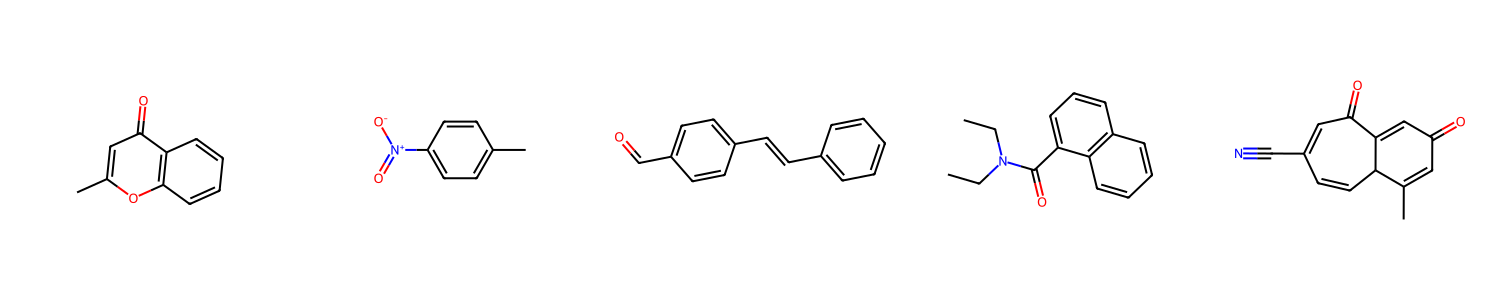

In [21]:
mols = []
for res in gpt_ft_gen:
    canon_smiles = Chem.MolFromSmiles(res['MOLECULE_SMILES'], sanitize=True)
    mols.append(canon_smiles)
    # Chem.Draw.MolToImage(canon_smiles)

Chem.Draw.MolsToGridImage(mols, subImgSize=(300,300), molsPerRow=5)

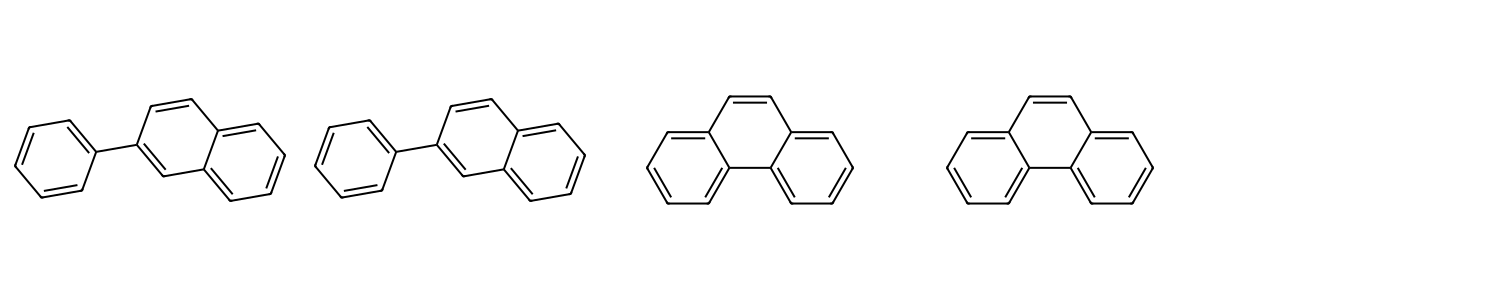

In [26]:
mols = []
for res in gpt_gen:
    if res['MOLECULE_SMILES']:
        canon_smiles = Chem.MolFromSmiles(res['MOLECULE_SMILES'], sanitize=True)
        mols.append(canon_smiles)
    # Chem.Draw.MolToImage(canon_smiles)

Chem.Draw.MolsToGridImage(mols, subImgSize=(300,300), molsPerRow=5)